Initialized


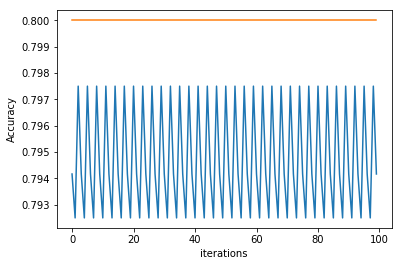

Train Accuracy: 0.79
Test Accuracy: 0.80


In [2]:
import tensorflow as tf
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
pp = pprint.PrettyPrinter(indent=4)
data = pd.read_csv (r'/Users/pavan/Downloads/0255 rawdata.csv')

X, y = data.iloc[:, :-1], data.iloc[:, -1]
kwargs = dict(test_size=3000, random_state=2000)
X_train, X_test, y_train, y_test = train_test_split(X, y, **kwargs)

# Convert DataFrame object into a numpy npdarray
data = data.values

# Define sizes of training and validations sets
train_size = 3000
valid_size = 2000
# Number of columns to use
num_fields = 27

# Choose a random subset
indices = np.random.choice(5000, train_size)
train_data = data[indices, :]

indices = np.random.choice(600, valid_size)
valid_data = data[indices, :]
# Seperate data from labels
#train_dataset = train_data[:, 2:]
#train_labels = train_data[:, :2]

#valid_dataset = valid_data[:, 2:]
#valid_labels = valid_data[:, :2]

train_dataset = train_data[:, 2:]
train_labels = train_data[:, :2]

valid_dataset = valid_data[:, 2:]
valid_labels = valid_data[:, :1]
# Clear space in memory
#del data
#del valid_data
#del train_data

# Define size of hidden layers
num_nodes_1 = 10
num_nodes_2 = int(num_nodes_1 * 0.5)
num_nodes_3 = int(num_nodes_1 * np.power(0.5, 2))
# Number of possible outputs
num_labels = 2
# Batch size
batch_size = 1200
# Beta for L2 regularization
beta = 0.02
starter_learning_rate = 0.001
regularizer_rate = 0.1

# Create a Tensorflow graph
graph = tf.Graph()

#graph = tf.get_default_graph()

with graph.as_default():
    # Create weights and biases
    def weights_and_biases(a, b):
        w = tf.Variable(tf.truncated_normal(shape=[a, b], stddev=np.sqrt(2 / a)))
        b = tf.Variable(tf.zeros([b]))
        return w, b

    # Create tensors for training data and labels and for
    # validation data
    tf_train_data = tf.placeholder(tf.float32, shape=[batch_size, num_fields])
    tf_train_labels = tf.placeholder(tf.float32, shape=[batch_size, num_labels])
    tf_valid_data = tf.constant(valid_dataset, dtype=tf.float32)
 # Assign weights and biases
    weights_1, biases_1 = weights_and_biases(num_fields, num_nodes_1)
    weights_2, biases_2 = weights_and_biases(num_nodes_1, num_nodes_2)
    weights_3, biases_3 = weights_and_biases(num_nodes_2, num_nodes_3)
    weights_4, biases_4 = weights_and_biases(num_nodes_3, num_labels)

    # Compute relu logits
    def relu_logits(data, drop=False):
        logits = tf.nn.relu(tf.matmul(data, weights_1) + biases_1)
        # Are we going to drop some values
        if drop:
            logits = tf.nn.dropout(logits, 0.5)
        logits = tf.nn.relu(tf.matmul(logits, weights_2) + biases_2)
        if drop:
            logits = tf.nn.dropout(logits, 0.5)
        logits = tf.nn.relu(tf.matmul(logits, weights_3) + biases_3)
        if drop:
            logits = tf.nn.dropout(logits, 0.5)
        logits = tf.matmul(logits, weights_4) + biases_4
 
        return logits

    # Logits for training data
    logits = relu_logits(tf_train_data, drop=True)
##print(logits)
 # Regular loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=tf_train_labels))
       
    # Regular loss
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=tf_train_labels)) \ regularizer_rate*(tf.reduce_sum(tf.square(biases_1)) + tf.reduce_sum(tf.square(biases_2)))
    # L2 loss
    reg = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3) + \
          tf.nn.l2_loss(weights_4)
    loss = tf.reduce_mean(loss + reg * beta)

    # Optimizer
    start_learn_rate = 0.01
    global_step = tf.Variable(0)
    # Create a decaying learning rate
    # start, global step, decay step, decay rate, staircase
    learn_rate = tf.train.exponential_decay(start_learn_rate, global_step, 10, 0.85, staircase=True)
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)
    #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    #Graph equations for Accuracy
    matches = tf.equal(tf.argmax(logits,1),tf.argmax(tf_train_labels,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))
    

## Variable learning rate
#learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
    # Training predictions
    train_predictions = tf.nn.softmax(logits)
    
    

    # Validation predictions
    logits = relu_logits(tf_valid_data)
    valid_predictions = tf.nn.softmax(logits)

# Number of training steps
num_steps = 100

# Compute accuracy of predictions if %
def accuracy(predictions, labels):
    
    return ((np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])-0.2)

    
#accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
training_accuracy = []
training_loss = []
testing_accuracy = []
tt_training_accuracy = []
tt_training_loss = []
tt_testing_accuracy = []
keep_prob = tf.placeholder(tf.float32)

# Create a Tensorflow session
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())

   # tf.global_variables_initializer().run()
   # total_batch = int(train_data.shape[0] / batch_size)
    print('Initialized')
    for step in range(num_steps):
        # Deffine an offset
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
         # Create batch data and labels
        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]

        feed_dict = {tf_train_data: batch_data, tf_train_labels: batch_labels}
       
         #Feeding CV data to the graphs
        acc_on_cv,loss_on_cv,preds_on_cv = session.run([optimizer,loss,tf.nn.softmax(logits)],
                                                    feed_dict = feed_dict)
                                                     
               #session.run(logits, feed_dict=feed_dict) 
        _, l, predictions = session.run([optimizer, loss, train_predictions], feed_dict=feed_dict)

       
        training_accuracy.append(accuracy(predictions, batch_labels))
        testing_accuracy .append(accuracy(valid_predictions.eval(), valid_labels))
        #testing_accuracy .append(accuracy(preds_on_cv, valid_labels))
     
    #Feeding test data to the graphs
    acc_on_test,loss_on_test,preds_on_test = session.run([acc,loss,tf.nn.softmax(logits)],
                                                    feed_dict = feed_dict
                                                            )
    #testing_accuracy .append(accuracy(preds_on_test, valid_labels))
    iterations = list(range(num_steps))
    plt.plot(iterations, training_accuracy, label='Train')
    plt.plot(iterations, testing_accuracy, label='Test')
    
    plt.ylabel('Accuracy')
    plt.xlabel('iterations')
    plt.show()
    #Calculating AUC on CV data
   # auc_on_test = roc_auc_score(train_predictions,preds_on_test)
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
      
print("Test Accuracy: {0:.2f}".format(testing_accuracy[-1])) 
